In [1]:
import numpy as np 
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import seaborn as sns 
import pickle
import pandas as pd
import time
import datetime
# sns.set()
# sns.set_style("ticks")
# sns.set_style("darkgrid")
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,  RANSACRegressor, TheilSenRegressor, Ridge 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
 

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import statsmodels.api as sm
from statsmodels.api import OLS

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Preprocessing

In [2]:
    Dataset = r'15minute_data_newyork\15minute_data_newyork.csv'
    fulldata = pd.read_csv(Dataset) 

    # savedata = r'SaveData\\'
    # Answers = r'Hw_Results\\'

In [3]:
data=fulldata[['dataid','local_15min','grid']]

In [4]:
data['dataid'].value_counts().count()

25

In [5]:
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])

In [6]:
ids=sorteddata['dataid'].unique().tolist()

In [7]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for regession 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)



In [8]:
# foo = foo[:-3]

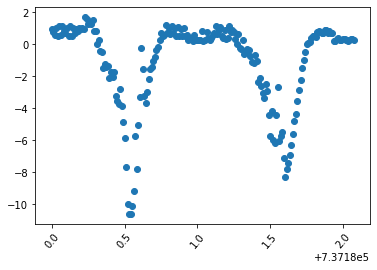

In [9]:
# housing_data[0].head(200).plot.scatter(x='local_15min', y='grid')

df = housing_data[0].head(200)
plt.xticks(rotation=50)
plt.scatter(df['15min_ints'], df['grid'])
# plt.plot(df['local_15min'], df['grid'])


In [10]:
housing_data[0]['local_15min']

0       2019-05-01 00:00:00
1       2019-05-01 00:15:00
2       2019-05-01 00:30:00
3       2019-05-01 00:45:00
4       2019-05-01 01:00:00
                ...        
17658   2019-10-31 22:45:00
17659   2019-10-31 23:00:00
17660   2019-10-31 23:15:00
17661   2019-10-31 23:30:00
17662   2019-10-31 23:45:00
Name: local_15min, Length: 17663, dtype: datetime64[ns]

In [11]:
housing_data[0]['15min_ints']

0        737180.000000
1        737180.010417
2        737180.020833
3        737180.031250
4        737180.041667
             ...      
17658    737363.947917
17659    737363.958333
17660    737363.968750
17661    737363.979167
17662    737363.989583
Name: 15min_ints, Length: 17663, dtype: float64

# Holt Winter

In [12]:
df = pd.DataFrame(housing_data[0], columns=['15min_ints','grid']).set_index('15min_ints')
RANDOM_SEED = 42
train_df = df.iloc[:-900, :]
test_df = df.iloc[-900:, :]
# train_df, val_df = train_test_split(df,test_size=0.15,random_state=RANDOM_SEED)
# val_df, test_df = train_test_split(val_df,test_size=0.33, random_state=RANDOM_SEED)
pred_df = test_df.copy()

In [13]:
# pred_df.sort_values(by = ['15min_ints']).plot(figsize=(12,3))

In [16]:
# model = HWES(train_df, trend="add", seasonal="add", seasonal_periods=130)
# model2 = HWES(train_df, trend="add", seasonal="add", seasonal_periods=130, damped=True)
model = HWES(train_df, trend="add", seasonal="add", damped_trend = True, initialization_method = 'legacy-heuristic',seasonal_periods=55)
model2 = HWES(train_df, trend="add", seasonal="add",  damped_trend=False, initialization_method = 'estimated', seasonal_periods =237)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
fit = model.fit()
fit2 = model2.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [18]:
pred = fit.forecast(900)
pred2 = fit2.forecast(900)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [19]:
sse1 = np.sqrt(np.mean(np.square(test_df.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test_df.values - pred2.values)))

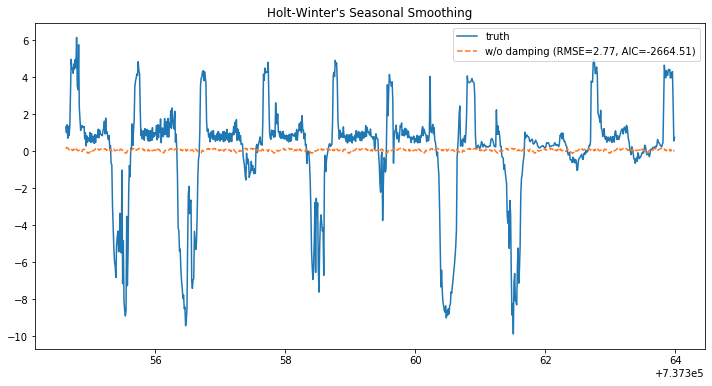

In [22]:

fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(train.index[60:], train.values[60:]);
ax.plot(test_df.index, test_df.values, label='truth');
ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
# ax.plot(test_df.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

# ACF

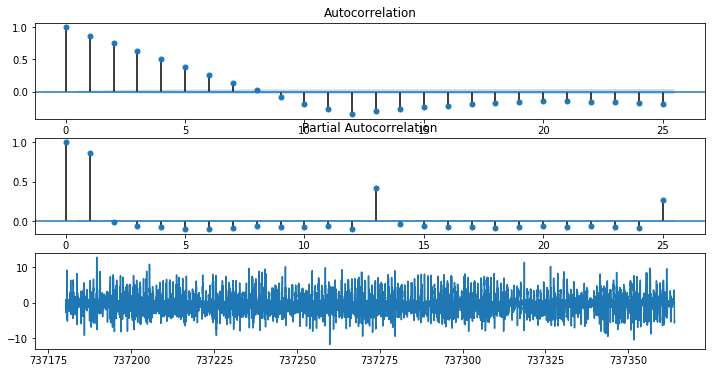

In [21]:
df['station'] = df.grid - df.grid.rolling(12).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (df.station.dropna() - df.station.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)